# Notebook Contents

- [Imports](#Imports)
- [Data](#Data)
- [Features](#Features)
- [Random Forest](#Random-Forest-Regression-Model)
    - [Fastball RHP](#Fastball-RHP)
    - [Fastball LHP](#Fastball-LHP)
    - [Breaking Ball RHP](#Breaking-Ball-RHP)
    - [BreakingBall LHP](#Breaking-Ball-LHP)
    - [Off-Speed RHP](#off-Speed-RHP)
    - [Off-Speed LHP](#Off-Speed-LHP)

# Imports

In [1]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from xgboost import XGBRegressor
from matplotlib.patches import Rectangle

import warnings
warnings.filterwarnings('ignore')

# Data

In [2]:
data = pd.read_csv('../data/model-pitches-rv.csv', index_col = [0])
pd.set_option('max_columns', None)
print(data.shape)
data.head()

(705434, 65)


,player_name,p_throws,pitch_type,velo,spin_rate,spin_axis,pfx_x,pfx_z,bauer_units,effective_speed,release_pos_x,release_pos_z,release_extension,release_pos_y,plate_x,plate_z,type,balls,strikes,pitch_count,stand,bb_type,description,events,hit_distance_sc,exit_velo,launch_angle,woba_value,woba_denom,xwoba,at_bat_number,pitch_number,inning,inning_topbot,home_score,away_score,post_home_score,post_away_score,on_1b,on_2b,on_3b,outs_when_up,pitch_type2,arm_angle,slot,whiff,is_strike,is_ball,final_pitch_ab,out_to_end_inning,home_runs,away_runs,runs,re,re_change,re_end_state,re24,lin_weight_above_avg,lin_weight_above_outs,woba_scale,lin_weights_above_avg_scale,lin_weights_above_outs_scale,woba,wraa_change,rv
0,"Smith, Will",L,FF,92.3,2330.0,148.0,-8.28,16.56,25.243770,92.8,-1.40,6.80,6.5,54.03,0.69,2.83,X,1,2,1-2,R,ground_ball,hit_into_play,field_out,13.0,95.2,-13.0,0.0,1.0,0.158,61,4,9,0,5,0,5,0,0,0,0,2,FF,36.0,1,0,1,0,1,1,0,0,0,0.11,-0.11,0.00,-0.11,-0.271,0.0,1.209,-0.328,0.0,0.222,-0.152,-0.110
1,"Smith, Will",L,SL,80.6,2254.0,315.0,9.24,5.76,27.965261,81.2,-1.60,6.64,6.4,54.15,0.71,2.62,S,1,1,1-1,R,NaN,strike,NaN,108.0,75.3,75.0,NaN,NaN,NaN,61,3,9,0,5,0,5,0,0,0,0,2,SL,45.8,2,0,1,0,0,0,0,0,0,0.11,0.00,0.11,0.00,NaN,NaN,1.209,0.000,0.0,0.300,-0.053,-0.053
2,"Smith, Will",L,CU,75.5,1940.0,328.0,7.80,-6.12,25.695364,75.2,-1.46,6.88,6.2,54.34,0.04,2.46,S,1,0,1-0,R,NaN,strike,NaN,157.0,83.5,65.0,NaN,NaN,NaN,61,2,9,0,5,0,5,0,0,0,0,2,CU,38.4,1,0,1,0,0,0,0,0,0,0.11,0.00,0.11,0.00,NaN,NaN,1.209,0.000,0.0,0.356,-0.038,-0.038
3,"Smith, Will",L,CU,75.0,2017.0,330.0,8.28,-8.28,26.893333,74.5,-1.53,6.83,5.9,54.61,-2.10,3.89,B,0,0,0-0,R,NaN,ball,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61,1,9,0,5,0,5,0,0,0,0,2,CU,38.4,1,0,0,1,0,0,0,0,0,0.11,0.00,0.11,0.00,NaN,NaN,1.209,0.000,0.0,0.314,0.028,0.028
4,"Smith, Will",L,FF,91.2,2281.0,143.0,-7.56,15.36,25.010965,90.9,-1.49,6.66,6.3,54.15,0.31,2.80,X,1,0,1-0,L,ground_ball,hit_into_play,field_out,9.0,93.3,-18.0,0.0,1.0,0.090,60,2,9,0,5,0,5,0,0,0,0,1,FF,36.0,1,0,1,0,1,0,0,0,0,0.29,-0.18,0.11,-0.18,-0.271,0.0,1.209,-0.328,0.0,0.356,-0.038,-0.180


# Cleaning / EDA

### Features

**Independent Variables:** Velocity, Spin Rate, HB, VB, Release Side, Release Height, Release Extension

**Dependent Variable:** Run Value

In [3]:
features = data[['player_name', 'p_throws', 'pitch_type', 'velo', 'pfx_x', 'pfx_z', 
                 'release_pos_x', 'release_pos_z', 'release_extension', 'rv']]

In [4]:
fb = features[features['pitch_type'].isin(['FF', 'SI'])]
bb = features[features['pitch_type'].isin(['SL', 'FC', 'CU', 'KC'])]
os = features[features['pitch_type'].isin(['CH', 'FS'])]
rhp = features.loc[features['p_throws'] == 'R']
lhp = features.loc[features['p_throws'] == 'L']
rhp_fb = fb.loc[fb['p_throws'] == 'R']
lhp_fb = fb.loc[fb['p_throws'] == 'L']
rhp_bb = bb.loc[bb['p_throws'] == 'R']
lhp_bb = bb.loc[bb['p_throws'] == 'L']
rhp_os = os.loc[os['p_throws'] == 'R']
lhp_os = os.loc[os['p_throws'] == 'L']

# XGBoost Regression Model

## Fastball RHP Grouped

#### 4-Seam, Sinker

In [5]:
print('Baseline RHP Fastball RunValue Accuracy Score:', round(rhp_fb.rv.mean(), 2))

Baseline RHP Fastball RunValue Accuracy Score: -0.01


In [6]:
features_fb_r = rhp_fb.select_dtypes([np.number])
X = features_fb_r.drop(columns = ['rv'])
y = features_fb_r['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 1)

xgb = XGBRegressor(max_depth = 3, learning_rate = 0.1, n_jobs = -1).fit(X_train, y_train)
pred_fb_r = xgb.predict(X_test)
pred = xgb.predict(X)

print('R2 Score:', round((metrics.r2_score(y_test, pred_fb_r)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_fb_r)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_fb_r), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Score: 0.002
Test RMSE: 0.262
Test MAE: 0.134 

R2 Score: 0.005
RMSE: 0.26
MAE: 0.133


### RHP Fastball Actual & Predicted Values

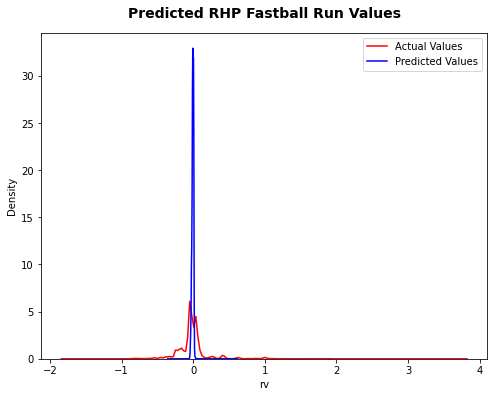

In [7]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted RHP Fastball Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

### RHP Fastball RV Table

Velocity, Spin Rate, HB, VB, Release Side, Release Height, Release Extension

In [8]:
rhp_fb['n_pitches'] = 1
rhp_fb['xRV'] = pred
rhp_fb['RV/100'] = round(((rhp_fb['rv'] / (rhp_fb['n_pitches'])) * 100), 2)
rhp_fb['xRV/100'] = round(((rhp_fb['xRV'] / (rhp_fb['n_pitches'])) * 100), 2)

grouped_fb_r = rhp_fb.groupby(['player_name', 'p_throws', 'pitch_type'], 
                              as_index = False)['n_pitches', 'rv', 'xRV',].sum()

avg_fb_r = rhp_fb.groupby(['player_name', 'p_throws', 'pitch_type'], 
                          as_index = False)['velo', 'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z', 
                                            'release_extension'].mean()
fb_r_rv_table = pd.merge(avg_fb_r, grouped_fb_r, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])

fb_r_rv_table['RV/100'] = round(((fb_r_rv_table['rv'] / (fb_r_rv_table['n_pitches'])) * 100), 2)
fb_r_rv_table['xRV/100'] = round(((fb_r_rv_table['xRV'] / (fb_r_rv_table['n_pitches'])) * 100), 2)

fb_r_rv_table.insert(3, 'n_pitches', fb_r_rv_table.pop('n_pitches'))
fb_r_rv_table = fb_r_rv_table.round(1)
print(fb_r_rv_table.shape)
fb_r_rv_table.sort_values(by = 'xRV').head(10)

(950, 14)


,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,release_pos_x,release_pos_z,release_extension,rv,xRV,RV/100,xRV/100
166,"Cole, Gerrit",R,FF,1397,97.7,12.0,18.0,1.9,5.7,6.6,-35.5,-41.400002,-2.5,-3.0
138,"Cease, Dylan",R,FF,1377,96.7,4.4,18.8,1.5,6.4,6.0,-6.9,-34.400002,-0.5,-2.5
661,"Pivetta, Nick",R,FF,1422,94.8,5.1,19.7,1.7,6.6,6.6,-19.9,-29.299999,-1.4,-2.1
901,"Wheeler, Zack",R,FF,1353,97.2,7.6,15.9,1.6,5.7,7.2,-36.9,-28.400000,-2.7,-2.1
106,"Buehler, Walker",R,FF,1400,95.3,3.0,18.0,0.8,5.8,6.4,-31.5,-27.400000,-2.2,-2.0
310,"Gilbert, Logan",R,FF,1305,95.3,5.4,18.0,2.0,6.0,7.5,-31.1,-27.000000,-2.4,-2.1
375,"Hendriks, Liam",R,FF,761,97.7,6.8,18.5,1.6,5.9,6.9,-26.1,-24.000000,-3.4,-3.2
949,"deGrom, Jacob",R,FF,704,99.2,9.1,16.4,1.1,5.5,6.9,-25.1,-22.900000,-3.6,-3.2
464,"Kopech, Michael",R,FF,725,97.3,9.8,18.5,2.1,5.8,6.6,-10.2,-21.500000,-1.4,-3.0
758,"Scherzer, Max",R,FF,1316,94.3,10.6,16.0,3.2,5.6,6.2,-33.9,-20.400000,-2.6,-1.6


### RHP Fastball xRV by HB & VB

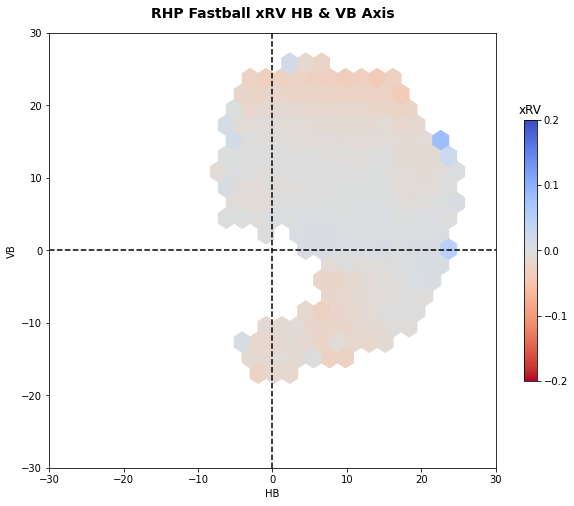

In [9]:
plt.figure(figsize = (10, 8))
plt.hexbin(rhp_fb['pfx_x'], rhp_fb['pfx_z'], C = rhp_fb['xRV'], cmap = 'coolwarm_r', 
           mincnt = 3, gridsize = 20)
cb = plt.colorbar(ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Fastball xRV HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);
#print('RHP Fastball Avg xRunValue:', round(rhp_fb.xRV.mean(), 2))

## Fastball LHP Grouped

#### 4-Seam, Sinker

In [10]:
print('Baseline LHP Fastball RunValue Accuracy Score:', round(lhp_fb.rv.mean(), 2))

Baseline LHP Fastball RunValue Accuracy Score: -0.01


In [11]:
features_fb_l = lhp_fb.select_dtypes([np.number])
X = features_fb_l.drop(columns = ['rv'])
y = features_fb_l['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 1)

xgb = XGBRegressor(max_depth = 3, learning_rate = 0.1, n_jobs = -1).fit(X_train, y_train)
pred_fb_l = xgb.predict(X_test)
pred = xgb.predict(X)

print('R2 Score:', round((metrics.r2_score(y_test, pred_fb_l)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_fb_l)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_fb_l), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Score: -0.0
Test RMSE: 0.253
Test MAE: 0.13 

R2 Score: 0.007
RMSE: 0.255
MAE: 0.131


### LHP Fastball Actual & Predicted Values

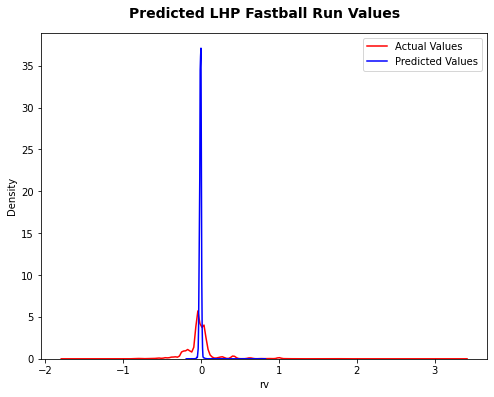

In [12]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted LHP Fastball Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Fastball RV Table

In [13]:
lhp_fb['n_pitches'] = 1
lhp_fb['xRV'] = pred
lhp_fb['RV/100'] = round(((lhp_fb['rv'] / (lhp_fb['n_pitches'])) * 100), 2)
lhp_fb['xRV/100'] = round(((lhp_fb['xRV'] / (lhp_fb['n_pitches'])) * 100), 2)
grouped_fb_l = lhp_fb.groupby(['player_name', 'p_throws', 'pitch_type'], 
                              as_index = False)['n_pitches', 'rv', 'xRV'].sum()

avg_fb_l = lhp_fb.groupby(['player_name', 'p_throws', 'pitch_type'], 
                          as_index = False)['velo', 'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z',
                                            'release_extension'].mean()
fb_l_rv_table = pd.merge(avg_fb_l, grouped_fb_l, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])

fb_l_rv_table['RV/100'] = round(((fb_l_rv_table['rv'] / (fb_l_rv_table['n_pitches'])) * 100), 2)
fb_l_rv_table['xRV/100'] = round(((fb_l_rv_table['xRV'] / (fb_l_rv_table['n_pitches'])) * 100), 2)

fb_l_rv_table.insert(3, 'n_pitches', fb_l_rv_table.pop('n_pitches'))
fb_l_rv_table = fb_l_rv_table.round(1)
print(fb_l_rv_table.shape)
fb_l_rv_table.sort_values(by = 'xRV').head(10)

(362, 14)


,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,release_pos_x,release_pos_z,release_extension,rv,xRV,RV/100,xRV/100
261,"Ray, Robbie",L,FF,1864,94.8,-8.2,17.1,-2.5,6.1,6.5,-47.3,-36.599998,-2.5,-2.0
185,"Manaea, Sean",L,SI,1782,92.1,-13.8,12.3,-3.3,5.6,7.2,-31.0,-24.900000,-1.7,-1.4
269,"Rodón, Carlos",L,FF,1302,95.4,-7.9,17.6,-2.0,6.7,6.1,-38.1,-21.400000,-2.9,-1.6
307,"Snell, Blake",L,FF,1230,95.1,-5.8,18.8,-1.9,6.6,6.8,-19.3,-18.799999,-1.6,-1.5
156,"Kikuchi, Yusei",L,FF,912,95.1,-10.2,16.3,-2.4,5.6,6.7,-13.4,-17.900000,-1.5,-2.0
125,"Hader, Josh",L,FF,593,96.4,-9.8,17.4,-3.1,5.3,6.7,-24.0,-17.600000,-4.0,-3.0
192,"Matzek, Tyler",L,FF,753,96.0,-4.9,18.0,-1.8,6.3,6.3,-22.8,-17.500000,-3.0,-2.3
132,"Heaney, Andrew",L,FF,1336,92.0,-15.3,15.2,-3.4,5.3,6.2,-18.7,-17.200001,-1.4,-1.3
191,"Matz, Steven",L,SI,1327,94.5,-15.0,12.3,-1.9,5.8,6.5,-19.9,-16.799999,-1.5,-1.3
272,"Rogers, Trevor",L,FF,1249,94.5,-11.1,14.8,-2.2,5.9,6.6,-32.6,-16.400000,-2.6,-1.3


### LHP Fastball xRV by HB & VB

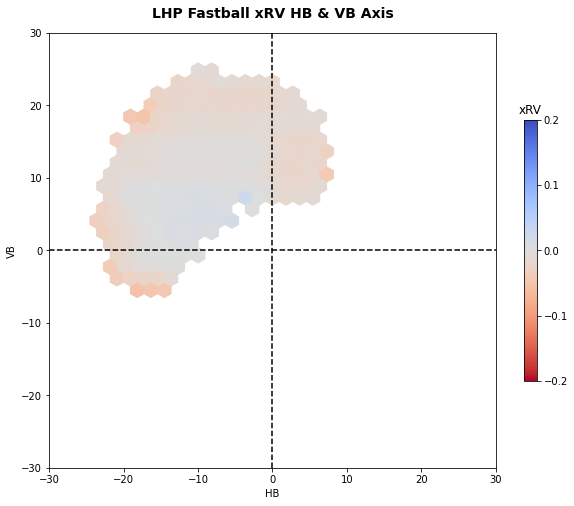

In [14]:
plt.figure(figsize = (10, 8))

plt.hexbin(lhp_fb['pfx_x'], lhp_fb['pfx_z'], C = lhp_fb['xRV'], cmap = 'coolwarm_r',
           mincnt = 5, gridsize = 20)
cb = plt.colorbar(ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Fastball xRV HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);
#print('LHP Fastball Avg xRunValue:', round(lhp_fb.xRV.mean(), 2))

## Breaking Ball RHP

#### Slider, Cutter, Curveball, Knuckle Curve

In [15]:
print('Baseline RHP Breaking Ball RunValue Accuracy Score:', round(rhp_bb.rv.mean(), 2))

Baseline RHP Breaking Ball RunValue Accuracy Score: -0.02


In [16]:
features_bb_r = rhp_bb.select_dtypes([np.number])
X = features_bb_r.drop(columns = ['rv'])
y = features_bb_r['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 1)

xgb = XGBRegressor(max_depth = 3, learning_rate = 0.1, n_jobs = -1).fit(X_train, y_train)
pred_bb_r = xgb.predict(X_test)
pred = xgb.predict(X)

print('R2 Test Score:', round((metrics.r2_score(y_test, pred_bb_r)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_bb_r)), 3))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_bb_r), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Test Score: -0.001
Test RMSE: 0.256
MAE: 0.129 

R2 Score: 0.006
Test RMSE: 0.253
MAE: 0.128


### RHP Breaking Ball Actual & Predicted Values

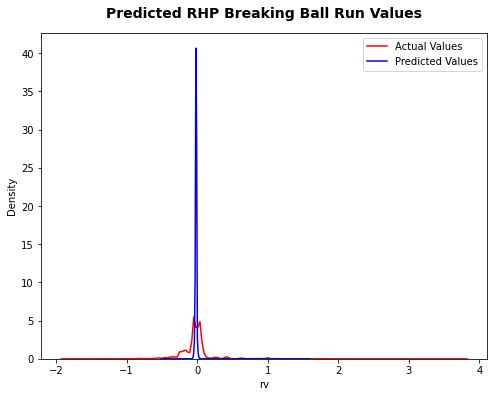

In [17]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted RHP Breaking Ball Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

### RHP Breaking Ball RV Table

In [18]:
rhp_bb['n_pitches'] = 1
rhp_bb['xRV'] = pred
rhp_bb['RV/100'] = round(((rhp_bb['rv'] / (rhp_bb['n_pitches'])) * 100), 2)
rhp_bb['xRV/100'] = round(((rhp_bb['xRV'] / (rhp_bb['n_pitches'])) * 100), 2)

grouped_bb_r = rhp_bb.groupby(['player_name', 'p_throws', 'pitch_type'], 
                              as_index = False)['n_pitches', 'rv', 'xRV',].sum()

avg_bb_r = rhp_bb.groupby(['player_name', 'p_throws', 'pitch_type'], 
                          as_index = False)['velo', 'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z', 
                                            'release_extension'].mean()
bb_r_rv_table = pd.merge(avg_bb_r, grouped_bb_r, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])

bb_r_rv_table['RV/100'] = round(((bb_r_rv_table['rv'] / (bb_r_rv_table['n_pitches'])) * 100), 2)
bb_r_rv_table['xRV/100'] = round(((bb_r_rv_table['xRV'] / (bb_r_rv_table['n_pitches'])) * 100), 2)

bb_r_rv_table.insert(3, 'n_pitches', bb_r_rv_table.pop('n_pitches'))
bb_r_rv_table = bb_r_rv_table.round(1)
print(bb_r_rv_table.shape)
bb_r_rv_table.sort_values(by = 'xRV').head(10)

(1065, 14)


,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,release_pos_x,release_pos_z,release_extension,rv,xRV,RV/100,xRV/100
123,"Burnes, Corbin",R,FC,1354,95.2,-4.2,11.2,0.9,5.9,6.4,-25.1,-31.799999,-1.8,-2.4
654,"Morton, Charlie",R,CU,1095,80.6,-16.6,-10.1,2.1,5.5,6.2,-39.3,-28.600000,-3.6,-2.6
79,"Berríos, José",R,CU,927,82.9,-15.0,-3.5,3.3,5.5,6.3,-22.8,-24.600000,-2.5,-2.7
659,"Musgrove, Joe",R,SL,815,84.1,-14.0,-1.6,1.4,6.4,5.9,-30.3,-23.000000,-3.7,-2.8
604,"McCullers Jr., Lance",R,SL,719,86.0,-13.7,4.6,1.7,5.1,6.0,-26.2,-22.900000,-3.6,-3.2
986,"Wainwright, Adam",R,CU,1027,73.5,-16.6,-14.7,1.2,6.4,6.4,-30.2,-21.700001,-2.9,-2.1
9,"Adams, Austin",R,SL,837,86.9,-10.0,0.8,3.4,5.3,5.8,-15.4,-20.100000,-1.8,-2.4
603,"McCullers Jr., Lance",R,KC,694,84.1,-11.9,-10.4,1.7,5.3,5.9,-19.1,-19.299999,-2.8,-2.8
175,"Clase, Emmanuel",R,FC,722,100.2,-2.7,10.7,0.7,6.2,6.4,-17.0,-17.500000,-2.4,-2.4
211,"Darvish, Yu",R,SL,629,81.6,-16.3,-1.8,1.7,5.8,6.2,-19.3,-17.299999,-3.1,-2.8


### RHP Breaking Ball xRV by HB & VB

RHP Breaking Ball Avg xRunValue: -0.02


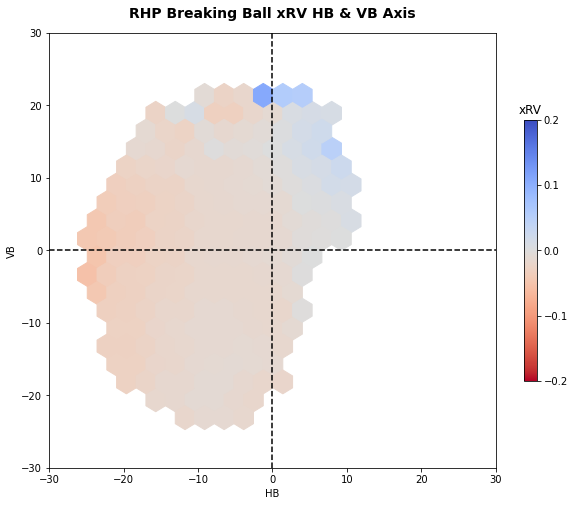

In [19]:
plt.figure(figsize = (10, 8))

plt.hexbin(rhp_bb['pfx_x'], rhp_bb['pfx_z'], C = rhp_bb['xRV'],cmap='coolwarm_r',
           mincnt = 10, gridsize = 20)
cb = plt.colorbar(ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Breaking Ball xRV HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);
print('RHP Breaking Ball Avg xRunValue:', round(rhp_bb.xRV.mean(), 2))

## Breaking Ball LHP
#### Slider, Cutter, Curveball, Knuckle Curve

In [20]:
print('Baseline LHP Breaking Ball RunValue Accuracy Score:', round(lhp_bb.rv.mean(), 2))

Baseline LHP Breaking Ball RunValue Accuracy Score: -0.02


In [21]:
features_bb_l = lhp_bb.select_dtypes([np.number])
X = features_bb_l.drop(columns = ['rv'])
y = features_bb_l['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 1)

xgb = XGBRegressor(max_depth = 3, learning_rate = 0.1, n_jobs = -1).fit(X_train, y_train)
pred_bb_l = xgb.predict(X_test)
pred = xgb.predict(X)

print('R2 Test Score:', round((metrics.r2_score(y_test, pred_bb_l)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_bb_l)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_bb_l), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Test Score: -0.001
Test RMSE: 0.258
Test MAE: 0.131 

R2 Score: 0.011
RMSE: 0.254
MAE: 0.129


### LHP Breaking Ball Actual & Predicted Values

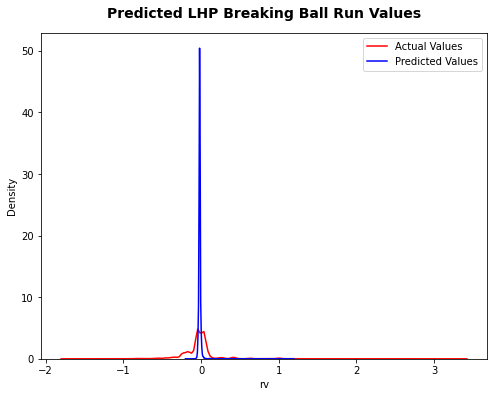

In [22]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted LHP Breaking Ball Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Breaking Ball RV Table

In [23]:
lhp_bb['n_pitches'] = 1
lhp_bb['xRV'] = pred
lhp_bb['RV/100'] = round(((lhp_bb['rv'] / (lhp_bb['n_pitches'])) * 100), 2)
lhp_bb['xRV/100'] = round(((lhp_bb['xRV'] / (lhp_bb['n_pitches'])) * 100), 2)
grouped_bb_l = lhp_bb.groupby(['player_name', 'p_throws', 'pitch_type'], 
                              as_index = False)['n_pitches', 'rv', 'xRV'].sum()

avg_bb_l = lhp_bb.groupby(['player_name', 'p_throws', 'pitch_type'], 
                          as_index = False)['velo', 'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z',
                                            'release_extension'].mean()
bb_l_rv_table = pd.merge(avg_bb_l, grouped_bb_l, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])

bb_l_rv_table['RV/100'] = round(((bb_l_rv_table['rv'] / (bb_l_rv_table['n_pitches'])) * 100), 2)
bb_l_rv_table['xRV/100'] = round(((bb_l_rv_table['xRV'] / (bb_l_rv_table['n_pitches'])) * 100), 2)

bb_l_rv_table.insert(3, 'n_pitches', bb_l_rv_table.pop('n_pitches'))
bb_l_rv_table = bb_l_rv_table.round(1)
print(bb_l_rv_table.shape)
bb_l_rv_table.sort_values(by = 'xRV').head(10)

(384, 14)


,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,release_pos_x,release_pos_z,release_extension,rv,xRV,RV/100,xRV/100
355,"Urías, Julio",L,CU,952,81.4,15.8,-0.9,-1.6,6.1,5.5,-38.7,-30.500000,-4.1,-3.2
220,"Miley, Wade",L,FC,1204,85.4,4.0,6.9,-1.7,6.5,6.1,-7.9,-23.000000,-0.6,-1.9
144,"Hill, Rich",L,CU,938,71.8,19.5,-12.3,-1.7,5.8,6.1,-23.6,-20.200001,-2.5,-2.2
212,"McClanahan, Shane",L,SL,674,89.2,3.8,2.0,-0.8,6.2,6.8,-22.5,-19.799999,-3.3,-2.9
357,"Valdez, Framber",L,CU,643,77.9,13.5,-15.3,-1.1,5.9,5.8,-26.3,-18.799999,-4.1,-2.9
158,"Kershaw, Clayton",L,SL,859,87.1,4.7,8.2,-1.5,6.2,6.3,-26.6,-18.700001,-3.1,-2.2
329,"Smyly, Drew",L,CU,897,78.9,-2.9,-0.2,-2.0,6.6,5.6,-19.0,-18.000000,-2.1,-2.0
286,"Ray, Robbie",L,SL,964,88.6,1.0,7.2,-2.6,6.0,6.3,-31.3,-17.600000,-3.2,-1.8
293,"Rodón, Carlos",L,SL,603,85.8,8.2,-1.1,-2.3,6.5,6.0,-30.1,-16.700001,-5.0,-2.8
333,"Snell, Blake",L,SL,571,86.5,4.3,1.1,-2.0,6.6,6.7,-14.6,-16.000000,-2.6,-2.8


### LHP Breaking Ball xRV by HB & VB

LHP Breaking Ball Avg xRunValue: -0.02


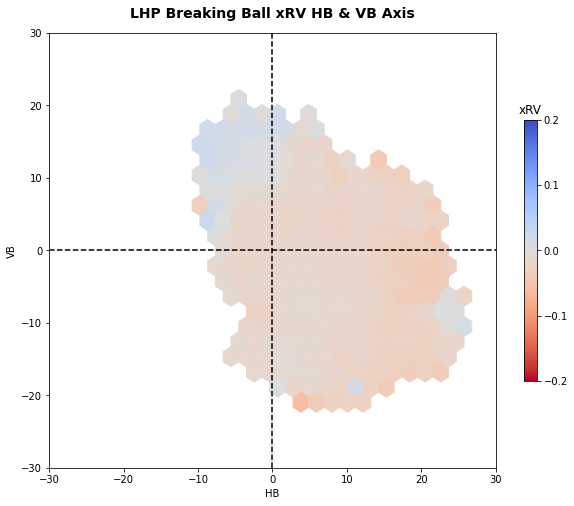

In [24]:
plt.figure(figsize = (10, 8))

plt.hexbin(lhp_bb['pfx_x'], lhp_bb['pfx_z'], C = lhp_bb['xRV'],cmap='coolwarm_r', 
           mincnt = 2, gridsize = 20)
cb = plt.colorbar(ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Breaking Ball xRV HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);
print('LHP Breaking Ball Avg xRunValue:', round(lhp_bb.xRV.mean(), 2))

## Off-Speed RHP

#### Changeup, Splitter

In [25]:
print('Baseline RHP Off-Speed RunValue Accuracy Score:', round(rhp_os.rv.mean(), 2))

Baseline RHP Off-Speed RunValue Accuracy Score: -0.01


In [26]:
features_os_r = rhp_os.select_dtypes([np.number])
X = features_os_r.drop(columns = ['rv'])
y = features_os_r['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 1)

xgb = XGBRegressor(max_depth = 3, learning_rate = 0.1, n_jobs = -1).fit(X_train, y_train)
pred_os_r = xgb.predict(X_test)
pred = xgb.predict(X)

print('R2 Score:', round((metrics.r2_score(y_test, pred_os_r)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_os_r)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_os_r), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Score: -0.0
Test RMSE: 0.26
Test MAE: 0.136 

R2 Score: 0.011
RMSE: 0.258
MAE: 0.137


### RHP Off-Speed Actual & Predicted Run Values

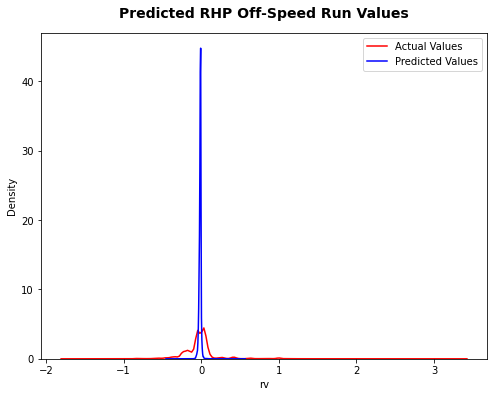

In [27]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted RHP Off-Speed Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

### RHP Off-Speed RV Table

In [28]:
rhp_os['n_pitches'] = 1
rhp_os['xRV'] = pred
rhp_os['RV/100'] = round(((rhp_os['rv'] / (rhp_os['n_pitches'])) * 100), 2)
rhp_os['xRV/100'] = round(((rhp_os['xRV'] / (rhp_os['n_pitches'])) * 100), 2)

grouped_os_r = rhp_os.groupby(['player_name', 'p_throws', 'pitch_type'], 
                              as_index = False)['n_pitches', 'rv', 'xRV',].sum()

avg_os_r = rhp_os.groupby(['player_name', 'p_throws', 'pitch_type'], 
                          as_index = False)['velo', 'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z', 
                                            'release_extension'].mean()
os_r_rv_table = pd.merge(avg_os_r, grouped_os_r, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])

os_r_rv_table['RV/100'] = round(((os_r_rv_table['rv'] / (os_r_rv_table['n_pitches'])) * 100), 2)
os_r_rv_table['xRV/100'] = round(((os_r_rv_table['xRV'] / (os_r_rv_table['n_pitches'])) * 100), 2)

os_r_rv_table.insert(3, 'n_pitches', os_r_rv_table.pop('n_pitches'))
os_r_rv_table = os_r_rv_table.round(1)
print(os_r_rv_table.shape)
os_r_rv_table.sort_values(by = 'xRV').head(10)

(522, 14)


,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,release_pos_x,release_pos_z,release_extension,rv,xRV,RV/100,xRV/100
322,"Montas, Frankie",R,FS,677,87.5,11.5,3.8,1.2,6.2,6.0,-27.6,-21.500000,-4.1,-3.2
76,"Castillo, Luis",R,CH,952,88.3,16.8,0.9,2.8,5.0,5.6,-28.1,-19.799999,-3.0,-2.1
152,"Flexen, Chris",R,CH,431,82.7,12.2,9.6,0.8,6.7,6.0,-16.5,-17.900000,-3.8,-4.2
504,"Williams, Devin",R,CH,621,83.7,17.0,-4.2,2.3,5.4,6.8,-20.7,-16.299999,-3.3,-2.6
7,"Alcantara, Sandy",R,CH,728,91.8,16.1,3.3,2.3,6.0,6.0,-18.0,-15.100000,-2.5,-2.1
176,"Gausman, Kevin",R,FS,1044,83.6,12.3,2.2,2.7,5.9,6.5,-50.0,-14.000000,-4.8,-1.3
183,"Giolito, Lucas",R,CH,940,81.5,10.2,12.9,1.6,6.4,6.7,-22.0,-13.600000,-2.3,-1.4
343,"Ohtani, Shohei",R,FS,366,88.1,4.9,2.4,1.8,6.2,6.8,-23.5,-13.200000,-6.4,-3.6
197,"Greinke, Zack",R,CH,569,86.4,12.8,4.5,1.4,6.3,5.9,-12.7,-12.200000,-2.2,-2.1
492,"Webb, Logan",R,CH,516,86.2,8.9,-5.0,2.0,5.0,6.7,-10.2,-11.900000,-2.0,-2.3


### RHP Off-Speed xRV by HB & VB

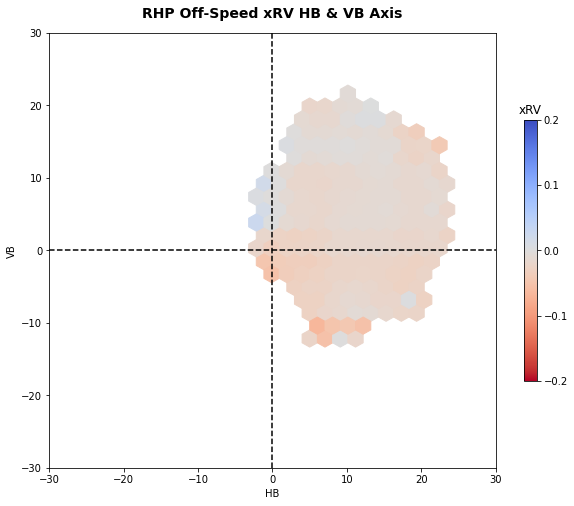

In [29]:
plt.figure(figsize = (10, 8))

plt.hexbin(rhp_os['pfx_x'], rhp_os['pfx_z'], C = rhp_os['xRV'], cmap = 'coolwarm_r',
           mincnt = 5, gridsize = 20)
cb = plt.colorbar(ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Off-Speed xRV HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);
#print('RHP Off-Speed Avg xRunValue:', round(rhp_os.xRV.mean(), 2))

## Off-speed LHP
#### Changeup, Splitter

In [30]:
print('Baseline LHP Off-Speed RunValue Accuracy Score:', round(lhp_os.rv.mean(), 2))

Baseline LHP Off-Speed RunValue Accuracy Score: -0.01


In [31]:
features_os_l = lhp_os.select_dtypes([np.number])
X = features_os_l.drop(columns = ['rv'])
y = features_os_l['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 1)

xgb = XGBRegressor(max_depth = 3, learning_rate = 0.1, n_jobs = -1).fit(X_train, y_train)
pred_os_l = xgb.predict(X_test)
pred = xgb.predict(X)

print('R2 Score:', round((metrics.r2_score(y_test, pred_os_l)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_os_l)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_os_l), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Score: -0.005
Test RMSE: 0.265
Test MAE: 0.139 

R2 Score: 0.021
RMSE: 0.263
MAE: 0.138


### LHP Off-Speed Actual & Predicted Values

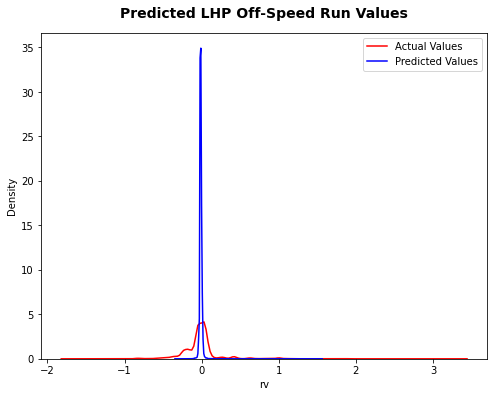

In [32]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted LHP Off-Speed Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Off-Speed RV Table

In [33]:
lhp_os['n_pitches'] = 1
lhp_os['xRV'] = pred
lhp_os['RV/100'] = round(((lhp_os['rv'] / (lhp_os['n_pitches'])) * 100), 2)
lhp_os['xRV/100'] = round(((lhp_os['xRV'] / (lhp_os['n_pitches'])) * 100), 2)
grouped_os_l = lhp_os.groupby(['player_name', 'p_throws', 'pitch_type'], 
                              as_index = False)['n_pitches', 'rv', 'xRV'].sum()

avg_os_l = lhp_os.groupby(['player_name', 'p_throws', 'pitch_type'], 
                          as_index = False)['velo', 'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z',
                                            'release_extension'].mean()
os_l_rv_table = pd.merge(avg_os_l, grouped_os_l, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])

os_l_rv_table['RV/100'] = round(((os_l_rv_table['rv'] / (os_l_rv_table['n_pitches'])) * 100), 2)
os_l_rv_table['xRV/100'] = round(((os_l_rv_table['xRV'] / (os_l_rv_table['n_pitches'])) * 100), 2)

os_l_rv_table.insert(3, 'n_pitches', os_l_rv_table.pop('n_pitches'))
os_l_rv_table = os_l_rv_table.round(1)
print(os_l_rv_table.shape)
os_l_rv_table.sort_values(by = 'xRV').head(10)

(186, 14)


,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,release_pos_x,release_pos_z,release_extension,rv,xRV,RV/100,xRV/100
98,"Manaea, Sean",L,CH,723,84.5,-12.2,6.7,-3.2,5.9,7.2,-21.4,-21.799999,-3.0,-3.0
139,"Rodriguez, Eduardo",L,CH,627,85.4,-16.7,6.5,-1.8,5.9,6.1,-9.4,-13.200000,-1.5,-2.1
101,"Matz, Steven",L,CH,598,85.1,-15.9,3.3,-1.9,5.7,6.5,-19.9,-12.400000,-3.3,-2.1
181,"Yarbrough, Ryan",L,CH,695,78.4,-17.4,6.4,-2.7,5.3,6.7,-2.3,-11.800000,-0.3,-1.7
80,"Keuchel, Dallas",L,CH,779,79.6,-14.7,5.2,-1.3,6.1,6.1,-8.5,-11.100000,-1.1,-1.4
145,"Ryu, Hyun Jin",L,CH,684,79.9,-14.0,6.7,-2.4,5.7,6.5,-12.1,-10.900000,-1.8,-1.6
143,"Rogers, Trevor",L,CH,595,84.8,-13.4,1.5,-2.2,5.8,6.8,-17.3,-10.500000,-2.9,-1.8
104,"Means, John",L,CH,635,83.4,-12.8,17.0,-0.6,6.5,6.1,-13.5,-10.400000,-2.1,-1.6
23,"Bubic, Kris",L,CH,675,80.0,-12.7,7.6,-1.4,5.6,6.6,-5.1,-9.200000,-0.8,-1.4
105,"Miley, Wade",L,CH,697,81.9,-14.8,6.8,-2.0,6.2,6.1,-10.3,-9.100000,-1.5,-1.3


### LHP Off-Speed xRV by HB & VB

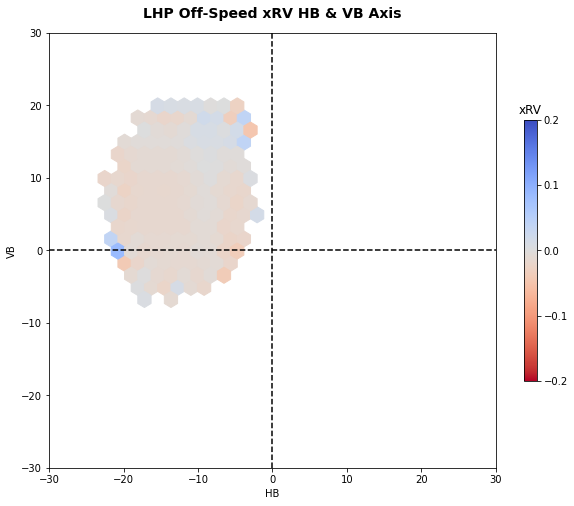

In [34]:
plt.figure(figsize = (10, 8))

plt.hexbin(lhp_os['pfx_x'], lhp_os['pfx_z'], C = lhp_os['xRV'], cmap = 'coolwarm_r',
           mincnt = 5, gridsize = 20)
cb = plt.colorbar(ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Off-Speed xRV HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);
#print('LHP Off-Speed Avg xRunValue:', round(lhp_os.xRV.mean(), 2))

## Save Grouped RV Tables to CSV

In [35]:
#xrv_grouped = pd.concat([rhp_fb, lhp_fb, rhp_bb, lhp_bb, rhp_os, lhp_os], ignore_index = True)
#xrv_grouped.fillna(0, inplace = True)
#xrv_grouped.to_csv('../data/xrv_grouped.csv')